# Классификация текстов BBC по уровню сложности
Цель: построить систему определения уровня сложности текстового сообщения (Easy / Medium / Hard) на основе корпуса BBC.

## План
1. Изучить датасет: покрытие, структура, показатели читаемости.
2. Выделить классы сложности по метрике Flesch, оценить баланс классов.
3. Провести предобработку текста, добавить числовые признаки читаемости.
4. Обучить классические модели (LogReg, Linear SVM, Multinomial NB) и ансамбль.
5. Проанализировать ошибки и показать генерацию аудиоданных через TTS для расширения корпуса.

In [32]:
import subprocess
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import clone

plt.style.use('seaborn-v0_8-whitegrid')
SEED = 42
rng = np.random.default_rng(SEED)
from sklearn.calibration import CalibratedClassifierCV

In [33]:
DATA_PATH = Path('bbc_news_text_complexity_summarization.csv')
df = pd.read_csv(DATA_PATH)
df.head()

,text,labels,no_sentences,Flesch Reading Ease Score,Dale-Chall Readability Score,text_rank_summary,lsa_summary
0,Ad sales boost Time Warner profit\r\n\r\nQuart...,business,26,62.17,9.72,It hopes to increase subscribers by offering t...,Its profits were buoyed by one-off gains which...
1,Dollar gains on Greenspan speech\r\n\r\nThe do...,business,17,65.56,9.09,The dollar has hit its highest level against t...,"""I think the chairman's taking a much more san..."
2,Yukos unit buyer faces loan claim\r\n\r\nThe o...,business,14,69.21,9.66,The owners of embattled Russian oil giant Yuko...,Yukos' owner Menatep Group says it will ask Ro...
3,High fuel prices hit BA's profits\r\n\r\nBriti...,business,24,62.98,9.86,Looking ahead to its full year results to Marc...,"Rod Eddington, BA's chief executive, said the ..."
4,Pernod takeover talk lifts Domecq\r\n\r\nShare...,business,17,70.63,10.23,Reports in the Wall Street Journal and the Fin...,Shares in UK drinks and food firm Allied Domec...


In [34]:
print(f"Количество текстов: {len(df):,}")
print(f"Доступные тематики: {sorted(df['labels'].unique())}")
print('Столбцы набора данных:')
print(df.dtypes)

length_stats = df['text'].str.len().describe(percentiles=[0.1, 0.5, 0.9])
word_stats = df['text'].str.split().str.len().describe(percentiles=[0.1, 0.5, 0.9])
flesch_stats = df['Flesch Reading Ease Score'].describe()
dale_stats = df['Dale-Chall Readability Score'].describe()

print()
print('Длина текста (символы):')
print(length_stats)
print()
print('Длина текста (слова):')
print(word_stats)
print()
print('Flesch Reading Ease Score:')
print(flesch_stats)
print()
print('Dale-Chall Readability Score:')
print(dale_stats)

missing = df.isna().mean().sort_values(ascending=False)
print()
print('Пропуски по признакам:')
print(missing)

Количество текстов: 2,127
Доступные тематики: ['business', 'entertainment', 'politics', 'sport', 'tech']
Столбцы набора данных:
text                             object
labels                           object
no_sentences                      int64
Flesch Reading Ease Score       float64
Dale-Chall Readability Score    float64
text_rank_summary                object
lsa_summary                      object
dtype: object

Длина текста (символы):
count     2127.000000
mean      2273.606018
std       1388.306653
min        506.000000
10%       1125.600000
50%       1968.000000
90%       3642.200000
max      25596.000000
Name: text, dtype: float64

Длина текста (слова):
count    2127.000000
mean      384.112835
std       241.399741
min        89.000000
10%       189.000000
50%       331.000000
90%       615.400000
max      4432.000000
Name: text, dtype: float64

Flesch Reading Ease Score:
count    2127.000000
mean       63.645548
std         8.466323
min        33.410000
25%        58.210000

In [35]:
quantiles = df['Flesch Reading Ease Score'].quantile([1/3, 2/3]).to_dict()
q1 = quantiles[1/3]
q2 = quantiles[2/3]
print(f"Порог Easy (>= {q2:.2f}), Hard (< {q1:.2f}), Medium -- между порогами.")

Порог Easy (>= 67.59), Hard (< 59.81), Medium -- между порогами.


In [36]:
def map_complexity(flesch: float) -> str:
    if flesch >= q2:
        return 'Easy'
    if flesch < q1:
        return 'Hard'
    return 'Medium'

df['complexity'] = df['Flesch Reading Ease Score'].apply(map_complexity)
df['complexity'].value_counts()

complexity
Easy      720
Hard      709
Medium    698
Name: count, dtype: int64

C:\Users\matve\AppData\Local\Temp\ipykernel_26476\3835476253.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='complexity', data=df, order=['Easy', 'Medium', 'Hard'], palette='crest', ax=ax)


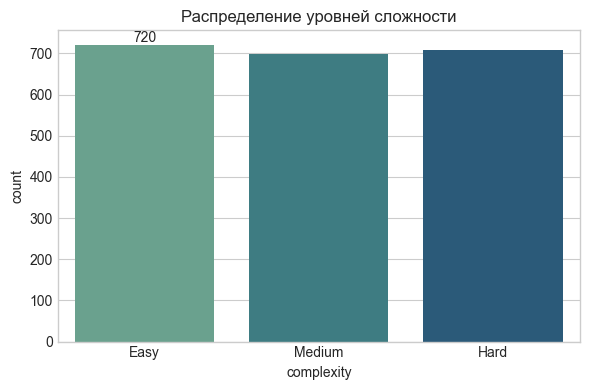

In [37]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='complexity', data=df, order=['Easy', 'Medium', 'Hard'], palette='crest', ax=ax)
ax.set_title('Распределение уровней сложности')
ax.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

In [38]:
import re

clean_pattern = re.compile(r'[^a-z\s]')

def normalize_text(text: str) -> str:
    text = text.lower().strip()
    text = text.replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text)
    text = clean_pattern.sub(' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def compute_word_length(text: str) -> float:
    tokens = [token for token in re.findall(r'[a-zA-Z]+', text)]
    if not tokens:
        return 0.0
    return sum(len(token) for token in tokens) / len(tokens)

df['clean_text'] = df['text'].apply(normalize_text)
df['word_count'] = df['clean_text'].str.split().str.len()
df['char_count'] = df['clean_text'].str.len()
df['avg_word_length'] = df['text'].apply(compute_word_length)
df['avg_sentence_length'] = df['word_count'] / df['no_sentences'].clip(lower=1)


df['summary_clean'] = df['text_rank_summary'].fillna('').apply(normalize_text)
df['combined_text'] = (df['clean_text'] + ' ' + df['summary_clean']).str.strip()
df[['text', 'clean_text', 'summary_clean', 'combined_text', 'word_count', 'avg_sentence_length', 'avg_word_length', 'Flesch Reading Ease Score', 'Dale-Chall Readability Score', 'complexity']].head()

,text,clean_text,summary_clean,combined_text,word_count,avg_sentence_length,avg_word_length,Flesch Reading Ease Score,Dale-Chall Readability Score,complexity
0,Ad sales boost Time Warner profit\r\n\r\nQuart...,ad sales boost time warner profit quarterly pr...,it hopes to increase subscribers by offering t...,ad sales boost time warner profit quarterly pr...,421,16.192308,4.707838,62.17,9.72,Medium
1,Dollar gains on Greenspan speech\r\n\r\nThe do...,dollar gains on greenspan speech the dollar ha...,the dollar has hit its highest level against t...,dollar gains on greenspan speech the dollar ha...,393,23.117647,4.567430,65.56,9.09,Medium
2,Yukos unit buyer faces loan claim\r\n\r\nThe o...,yukos unit buyer faces loan claim the owners o...,the owners of embattled russian oil giant yuko...,yukos unit buyer faces loan claim the owners o...,269,19.214286,4.587361,69.21,9.66,Easy
3,High fuel prices hit BA's profits\r\n\r\nBriti...,high fuel prices hit ba s profits british airw...,looking ahead to its full year results to marc...,high fuel prices hit ba s profits british airw...,395,16.458333,4.600000,62.98,9.86,Medium
4,Pernod takeover talk lifts Domecq\r\n\r\nShare...,pernod takeover talk lifts domecq shares in uk...,reports in the wall street journal and the fin...,pernod takeover talk lifts domecq shares in uk...,266,15.647059,4.590226,70.63,10.23,Easy


In [39]:
numeric_features = ['no_sentences', 'word_count', 'char_count', 'avg_word_length', 'avg_sentence_length', 'Flesch Reading Ease Score', 'Dale-Chall Readability Score']
target_col = 'complexity'
text_col = 'clean_text'

In [40]:
feature_columns = [text_col, 'summary_clean', 'combined_text'] + numeric_features + [target_col, 'text']

train_full, test_df = train_test_split(
    df[feature_columns],
    test_size=0.2,
    random_state=SEED,
    stratify=df[target_col]
)
train_df, val_df = train_test_split(
    train_full,
    test_size=0.2,
    random_state=SEED,
    stratify=train_full[target_col]
)
print(f"Train/Val/Test размеры: {len(train_df)}/{len(val_df)}/{len(test_df)}")

Train/Val/Test размеры: 1360/341/426


In [41]:

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
)
import warnings

label_encoder = LabelEncoder()
label_encoder.fit(train_full[target_col])
class_names = label_encoder.classes_
num_classes = len(class_names)


evaluation_results = {}
model_probabilities = {}
model_predictions = {}
confusion_matrices = {}
classification_reports = {}

def align_probabilities(model_classes, probabilities):
    index_map = [np.where(model_classes == cls)[0][0] for cls in class_names]
    return probabilities[:, index_map]

def collect_metrics(model_name: str, true_labels, probabilities):
    """Compute and store evaluation metrics for a classifier."""
    true_labels = pd.Series(true_labels).reset_index(drop=True)
    probabilities = np.asarray(probabilities)
    pred_indices = probabilities.argmax(axis=1)
    pred_labels = class_names[pred_indices]

    model_predictions[model_name] = pred_labels
    model_probabilities[model_name] = probabilities

    y_true_encoded = label_encoder.transform(true_labels)
    y_true_onehot = label_binarize(y_true_encoded, classes=np.arange(num_classes))

    metrics = {}
    metrics['accuracy'] = accuracy_score(true_labels, pred_labels)
    metrics['macro_f1'] = f1_score(true_labels, pred_labels, average='macro')
    metrics['weighted_f1'] = f1_score(true_labels, pred_labels, average='weighted')

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        metrics['roc_auc'] = roc_auc_score(y_true_onehot, probabilities, average='macro', multi_class='ovr')
        metrics['pr_auc'] = average_precision_score(y_true_onehot, probabilities, average='macro')

    evaluation_results[model_name] = metrics

    cm = confusion_matrix(true_labels, pred_labels, labels=class_names)
    confusion_matrices[model_name] = pd.DataFrame(cm, index=class_names, columns=class_names)
    classification_reports[model_name] = classification_report(true_labels, pred_labels, output_dict=True)
    return metrics


In [42]:
text_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=1,
    max_df=0.98,
    stop_words=None,
    sublinear_tf=True
)
numeric_transformer = MaxAbsScaler()
column_transformer = ColumnTransformer(
    transformers=[
        ('text', text_vectorizer, 'combined_text'),
        ('numeric', numeric_transformer, numeric_features)
    ]
)

pipelines = {
    'LogReg': Pipeline([
        ('features', column_transformer),
        ('clf', LogisticRegression(max_iter=2000, C=6.0, solver='lbfgs', multi_class='multinomial'))
    ]),
    'LinearSVM': Pipeline([
        ('features', column_transformer),
        ('clf', SVC(kernel='linear', C=6.0, probability=True, random_state=SEED))
    ]),
    'MultinomialNB': Pipeline([
        ('tfidf', TfidfVectorizer(
            ngram_range=(1, 2),
            min_df=1,
            max_df=0.98,
            stop_words=None,
            sublinear_tf=True
        )),
        ('clf', MultinomialNB(alpha=0.1))
    ])
}


In [43]:
val_scores = {}
val_probabilities = {}
trained_val_models = {}

for name, pipe in pipelines.items():
    model = clone(pipe)
    if name == 'MultinomialNB':
        X_train_in = train_df['combined_text']
        X_val_in = val_df['combined_text']
    else:
        X_train_in = train_df.drop(columns=[target_col, 'text'])
        X_val_in = val_df.drop(columns=[target_col, 'text'])
    model.fit(X_train_in, train_df[target_col])
    preds = model.predict(X_val_in)
    acc = accuracy_score(val_df[target_col], preds)
    val_scores[name] = acc
    if hasattr(model, 'predict_proba'):
        val_probabilities[name] = model.predict_proba(X_val_in)
    trained_val_models[name] = model
    print(f"{name}: точность на валидации = {acc:.3f}")

c:\Users\matve\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogReg: точность на валидации = 0.865
LinearSVM: точность на валидации = 0.918
MultinomialNB: точность на валидации = 0.548


In [44]:
class_order = trained_val_models['LogReg'].classes_
aligned_val_probs = {}
for name, model in trained_val_models.items():
    if name not in val_probabilities:
        continue
    model_classes = model.classes_
    index_map = [np.where(model_classes == cls)[0][0] for cls in class_order]
    aligned_val_probs[name] = val_probabilities[name][:, index_map]

weight_grid = np.arange(0.0, 1.01, 0.1)
best_weights = (1.0, 0.0)
best_val_acc = val_scores['LogReg']

if 'LogReg' in aligned_val_probs and 'LinearSVM' in aligned_val_probs:
    for w_lr in weight_grid:
        w_svm = 1 - w_lr
        if w_svm < 0:
            continue
        weights = np.array([w_lr, w_svm])
        combined = (weights[0] * aligned_val_probs['LogReg'] +
                    weights[1] * aligned_val_probs['LinearSVM'])
        ensemble_preds = class_order[np.argmax(combined, axis=1)]
        acc = accuracy_score(val_df[target_col], ensemble_preds)
        if acc > best_val_acc:
            best_val_acc = acc
            best_weights = (weights[0], weights[1])
print(f"Лучшие веса ансамбля (валидация): LogReg={best_weights[0]:.2f}, SVM={best_weights[1]:.2f}")
print(f"Точность ансамбля на валидации: {best_val_acc:.3f}")

Лучшие веса ансамбля (валидация): LogReg=0.00, SVM=1.00
Точность ансамбля на валидации: 0.912


In [45]:
final_models = {}
for name, pipe in pipelines.items():
    model = clone(pipe)
    if name == 'MultinomialNB':
        X_train_in = train_full['combined_text']
    else:
        X_train_in = train_full.drop(columns=[target_col, 'text'])
    model.fit(X_train_in, train_full[target_col])
    final_models[name] = model

test_labels = test_df[target_col]

c:\Users\matve\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [46]:

test_labels = test_df[target_col].reset_index(drop=True)
ensemble_name = None

for name, model in final_models.items():
    if name == 'MultinomialNB':
        probs_raw = model.predict_proba(test_df['combined_text'])
        probs = align_probabilities(model.classes_, probs_raw)
    else:
        features = test_df.drop(columns=[target_col, 'text'])
        probs_raw = model.predict_proba(features)
        probs = align_probabilities(model.classes_, probs_raw)
    collect_metrics(name, test_labels, probs)

if {'LogReg', 'LinearSVM'}.issubset(final_models.keys()):
    lr_raw = final_models['LogReg'].predict_proba(test_df.drop(columns=[target_col, 'text']))
    lr_prob = align_probabilities(final_models['LogReg'].classes_, lr_raw)

    svm_raw = final_models['LinearSVM'].predict_proba(test_df.drop(columns=[target_col, 'text']))
    svm_prob = align_probabilities(final_models['LinearSVM'].classes_, svm_raw)

    ensemble_prob = best_weights[0] * lr_prob + best_weights[1] * svm_prob
    ensemble_name = f"Ensemble (LR={best_weights[0]:.2f}, SVM={best_weights[1]:.2f})"
    collect_metrics(ensemble_name, test_labels, ensemble_prob)
else:
    ensemble_prob = None

metrics_df = (
    pd.DataFrame.from_dict(evaluation_results, orient='index')
    .sort_values('macro_f1', ascending=False)
    .round(4)
)
metrics_df


,accuracy,macro_f1,weighted_f1,roc_auc,pr_auc
LinearSVM,0.9038,0.9039,0.9043,0.9817,0.9652
"Ensemble (LR=0.00, SVM=1.00)",0.9038,0.9039,0.9043,0.9817,0.9652
LogReg,0.8662,0.8654,0.8660,0.9626,0.9214
MultinomialNB,0.5728,0.5611,0.5628,0.7502,0.6013


In [47]:

logreg_report = pd.DataFrame(classification_reports['LogReg']).transpose().round(3)
logreg_report


,precision,recall,f1-score,support
Easy,0.899,0.924,0.911,144.000
Hard,0.899,0.880,0.890,142.000
Medium,0.799,0.793,0.796,140.000
accuracy,0.866,0.866,0.866,0.866
macro avg,0.865,0.866,0.865,426.000
weighted avg,0.866,0.866,0.866,426.000


In [48]:

if ensemble_name and ensemble_name in classification_reports:
    pd.DataFrame(classification_reports[ensemble_name]).transpose().round(3)
else:
    'Ансамбль не сформирован'


# Нейросетевой подход: BiLSTM на PyTorch

In [49]:

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter

torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Используемое устройство: {device}')


Используемое устройство: cuda


In [50]:

def simple_tokenize(text: str):
    return text.split()

counter = Counter()
for text in train_df['combined_text']:
    counter.update(simple_tokenize(text))

MAX_VOCAB_SIZE = 20000
vocab_tokens = [token for token, _ in counter.most_common(MAX_VOCAB_SIZE)]
PAD_IDX = 0
UNK_IDX = 1
token_to_id = {token: idx + 2 for idx, token in enumerate(vocab_tokens)}

print(f'Размер словаря: {len(token_to_id) + 2}')

MAX_SEQ_LEN = 400

def encode_text(text: str):
    tokens = simple_tokenize(text)
    encoded = [token_to_id.get(tok, UNK_IDX) for tok in tokens]
    if not encoded:
        encoded = [UNK_IDX]
    return encoded[:MAX_SEQ_LEN]


Размер словаря: 20002


In [51]:

class NewsSequenceDataset(Dataset):
    def __init__(self, dataframe):
        self.texts = dataframe['combined_text'].tolist()
        self.labels = label_encoder.transform(dataframe[target_col]).astype(np.int64)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = encode_text(self.texts[idx])
        return torch.tensor(encoded, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def collate_batch(batch):
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long)
    padded = pad_sequence(sequences, batch_first=True, padding_value=PAD_IDX)
    labels = torch.stack(labels)
    return padded, lengths, labels

BATCH_SIZE_RNN = 32
train_dataset_rnn = NewsSequenceDataset(train_df)
val_dataset_rnn = NewsSequenceDataset(val_df)
test_dataset_rnn = NewsSequenceDataset(test_df)

train_loader_rnn = DataLoader(train_dataset_rnn, batch_size=BATCH_SIZE_RNN, shuffle=True, collate_fn=collate_batch)
val_loader_rnn = DataLoader(val_dataset_rnn, batch_size=BATCH_SIZE_RNN, shuffle=False, collate_fn=collate_batch)
test_loader_rnn = DataLoader(test_dataset_rnn, batch_size=64, shuffle=False, collate_fn=collate_batch)


In [52]:

class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, inputs, lengths):
        embedded = self.embedding(inputs)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, _) = self.lstm(packed)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        hidden = self.dropout(hidden)
        logits = self.fc(hidden)
        return logits

class_counts = train_df[target_col].value_counts()
class_weights = torch.tensor([len(train_df) / class_counts[cls] for cls in class_names], dtype=torch.float32)
class_weights = class_weights.to(device)

model_rnn = BiLSTMClassifier(vocab_size=len(token_to_id) + 2).to(device)
criterion_rnn = nn.CrossEntropyLoss(weight=class_weights)
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=1e-3)


In [53]:

def run_epoch(model, data_loader, criterion, optimizer=None):
    is_train = optimizer is not None
    total_loss = 0.0
    all_preds = []
    all_targets = []

    if is_train:
        model.train()
    else:
        model.eval()

    for inputs, lengths, labels in data_loader:
        inputs = inputs.to(device)
        lengths = lengths.to(device)
        labels = labels.to(device)

        if is_train:
            optimizer.zero_grad()

        logits = model(inputs, lengths)
        loss = criterion(logits, labels)

        if is_train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.detach().cpu().numpy())
        all_targets.append(labels.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    avg_loss = total_loss / len(data_loader.dataset)
    acc = accuracy_score(all_targets, all_preds)
    macro_f1 = f1_score(all_targets, all_preds, average='macro')

    return {
        'loss': avg_loss,
        'accuracy': acc,
        'macro_f1': macro_f1,
    }

EPOCHS_RNN = 10
best_state = None
best_macro_f1 = -np.inf
history_rnn = []

for epoch in range(1, EPOCHS_RNN + 1):
    train_metrics = run_epoch(model_rnn, train_loader_rnn, criterion_rnn, optimizer_rnn)
    val_metrics = run_epoch(model_rnn, val_loader_rnn, criterion_rnn, optimizer=None)
    history_rnn.append({'epoch': epoch, 'train': train_metrics, 'val': val_metrics})
    if val_metrics['macro_f1'] > best_macro_f1:
        best_macro_f1 = val_metrics['macro_f1']
        best_state = {k: v.cpu().clone() for k, v in model_rnn.state_dict().items()}
    print(f"Epoch {epoch}: train_loss={train_metrics['loss']:.4f}, val_macro_f1={val_metrics['macro_f1']:.4f}")

if best_state is not None:
    model_rnn.load_state_dict(best_state)


Epoch 1: train_loss=1.0978, val_macro_f1=0.3738
Epoch 2: train_loss=0.9950, val_macro_f1=0.3771
Epoch 3: train_loss=0.8145, val_macro_f1=0.3938
Epoch 4: train_loss=0.5223, val_macro_f1=0.4067
Epoch 5: train_loss=0.2648, val_macro_f1=0.4356
Epoch 6: train_loss=0.1024, val_macro_f1=0.4251
Epoch 7: train_loss=0.0433, val_macro_f1=0.4212
Epoch 8: train_loss=0.0185, val_macro_f1=0.4239
Epoch 9: train_loss=0.0156, val_macro_f1=0.4489
Epoch 10: train_loss=0.0066, val_macro_f1=0.4305


In [54]:

def predict_probabilities(model, data_loader):
    model.eval()
    probs = []
    with torch.no_grad():
        for inputs, lengths, _ in data_loader:
            inputs = inputs.to(device)
            lengths = lengths.to(device)
            logits = model(inputs, lengths)
            batch_probs = torch.softmax(logits, dim=1).cpu().numpy()
            probs.append(batch_probs)
    return np.vstack(probs)

rnn_test_probs = predict_probabilities(model_rnn, test_loader_rnn)
collect_metrics('BiLSTM', test_labels, rnn_test_probs)
metrics_df = (
    pd.DataFrame.from_dict(evaluation_results, orient='index')
    .sort_values('macro_f1', ascending=False)
    .round(4)
)
metrics_df


,accuracy,macro_f1,weighted_f1,roc_auc,pr_auc
LinearSVM,0.9038,0.9039,0.9043,0.9817,0.9652
"Ensemble (LR=0.00, SVM=1.00)",0.9038,0.9039,0.9043,0.9817,0.9652
LogReg,0.8662,0.8654,0.8660,0.9626,0.9214
MultinomialNB,0.5728,0.5611,0.5628,0.7502,0.6013
BiLSTM,0.4531,0.4540,0.4544,0.6343,0.4802


# Трансформерный подход: дообучение DistilBERT

In [55]:

import importlib
import subprocess
import sys

for package in ['transformers', 'accelerate']:
    if importlib.util.find_spec(package) is None:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])


In [56]:

from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup

MODEL_NAME = 'distilbert-base-uncased'
MAX_LENGTH = 256

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class TransformerDataset(Dataset):
    def __init__(self, dataframe):
        encodings = tokenizer(
            dataframe['combined_text'].tolist(),
            truncation=True,
            padding='max_length',
            max_length=MAX_LENGTH,
        )
        self.encodings = encodings
        self.labels = label_encoder.transform(dataframe[target_col]).astype(np.int64)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx], dtype=torch.long) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset_bert = TransformerDataset(train_df)
val_dataset_bert = TransformerDataset(val_df)
test_dataset_bert = TransformerDataset(test_df)

BATCH_SIZE_BERT = 8
train_loader_bert = DataLoader(train_dataset_bert, batch_size=BATCH_SIZE_BERT, shuffle=True)
val_loader_bert = DataLoader(val_dataset_bert, batch_size=16, shuffle=False)
test_loader_bert = DataLoader(test_dataset_bert, batch_size=16, shuffle=False)

model_bert = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes,
).to(device)

optimizer_bert = torch.optim.AdamW(model_bert.parameters(), lr=2e-5, weight_decay=0.01)
criterion_bert = nn.CrossEntropyLoss(weight=class_weights)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:

EPOCHS_BERT = 10
best_state_bert = None
best_val_f1_bert = -np.inf

total_steps = len(train_loader_bert) * EPOCHS_BERT
scheduler_bert = get_linear_schedule_with_warmup(
    optimizer_bert,
    num_warmup_steps=max(1, int(0.1 * total_steps)),
    num_training_steps=total_steps,
)

for epoch in range(1, EPOCHS_BERT + 1):
    model_bert.train()
    total_loss = 0.0
    for batch in train_loader_bert:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch.pop('labels')

        optimizer_bert.zero_grad()
        outputs = model_bert(**batch)
        logits = outputs.logits
        loss = criterion_bert(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_bert.parameters(), max_norm=1.0)
        optimizer_bert.step()
        scheduler_bert.step()
        total_loss += loss.item() * labels.size(0)

    avg_train_loss = total_loss / len(train_dataset_bert)

    model_bert.eval()
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for batch in val_loader_bert:
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch.pop('labels')
            outputs = model_bert(**batch)
            logits = outputs.logits
            val_preds.append(torch.argmax(logits, dim=1).cpu().numpy())
            val_targets.append(labels.cpu().numpy())

    val_preds = np.concatenate(val_preds)
    val_targets = np.concatenate(val_targets)
    val_macro_f1 = f1_score(val_targets, val_preds, average='macro')
    print(f'Epoch {epoch}: train_loss={avg_train_loss:.4f}, val_macro_f1={val_macro_f1:.4f}')

    if val_macro_f1 > best_val_f1_bert:
        best_val_f1_bert = val_macro_f1
        best_state_bert = {k: v.cpu().clone() for k, v in model_bert.state_dict().items()}

if best_state_bert is not None:
    model_bert.load_state_dict(best_state_bert)


Epoch 1: train_loss=1.0324, val_macro_f1=0.5114
Epoch 2: train_loss=0.8659, val_macro_f1=0.5875
Epoch 3: train_loss=0.7005, val_macro_f1=0.5801
Epoch 4: train_loss=0.5091, val_macro_f1=0.5773
Epoch 5: train_loss=0.3294, val_macro_f1=0.6006
Epoch 6: train_loss=0.1967, val_macro_f1=0.5930
Epoch 7: train_loss=0.0980, val_macro_f1=0.6013
Epoch 8: train_loss=0.0576, val_macro_f1=0.6278
Epoch 9: train_loss=0.0456, val_macro_f1=0.6317
Epoch 10: train_loss=0.0388, val_macro_f1=0.6110


In [58]:

model_bert.eval()
bert_probs = []
with torch.no_grad():
    for batch in test_loader_bert:
        batch = {k: v.to(device) for k, v in batch.items()}
        batch.pop('labels', None)
        logits = model_bert(**batch).logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        bert_probs.append(probs)

bert_probs = np.vstack(bert_probs)
collect_metrics('DistilBERT', test_labels, bert_probs)
metrics_df = (
    pd.DataFrame.from_dict(evaluation_results, orient='index')
    .sort_values('macro_f1', ascending=False)
    .round(4)
)
metrics_df


,accuracy,macro_f1,weighted_f1,roc_auc,pr_auc
LinearSVM,0.9038,0.9039,0.9043,0.9817,0.9652
"Ensemble (LR=0.00, SVM=1.00)",0.9038,0.9039,0.9043,0.9817,0.9652
LogReg,0.8662,0.8654,0.8660,0.9626,0.9214
DistilBERT,0.6221,0.6235,0.6244,0.7816,0.6519
MultinomialNB,0.5728,0.5611,0.5628,0.7502,0.6013
BiLSTM,0.4531,0.4540,0.4544,0.6343,0.4802


# Сводная оценка моделей

In [59]:

summary_df = (
    pd.DataFrame.from_dict(evaluation_results, orient='index')
    .sort_values('macro_f1', ascending=False)
    .round(4)
)
summary_df


,accuracy,macro_f1,weighted_f1,roc_auc,pr_auc
LinearSVM,0.9038,0.9039,0.9043,0.9817,0.9652
"Ensemble (LR=0.00, SVM=1.00)",0.9038,0.9039,0.9043,0.9817,0.9652
LogReg,0.8662,0.8654,0.8660,0.9626,0.9214
DistilBERT,0.6221,0.6235,0.6244,0.7816,0.6519
MultinomialNB,0.5728,0.5611,0.5628,0.7502,0.6013
BiLSTM,0.4531,0.4540,0.4544,0.6343,0.4802


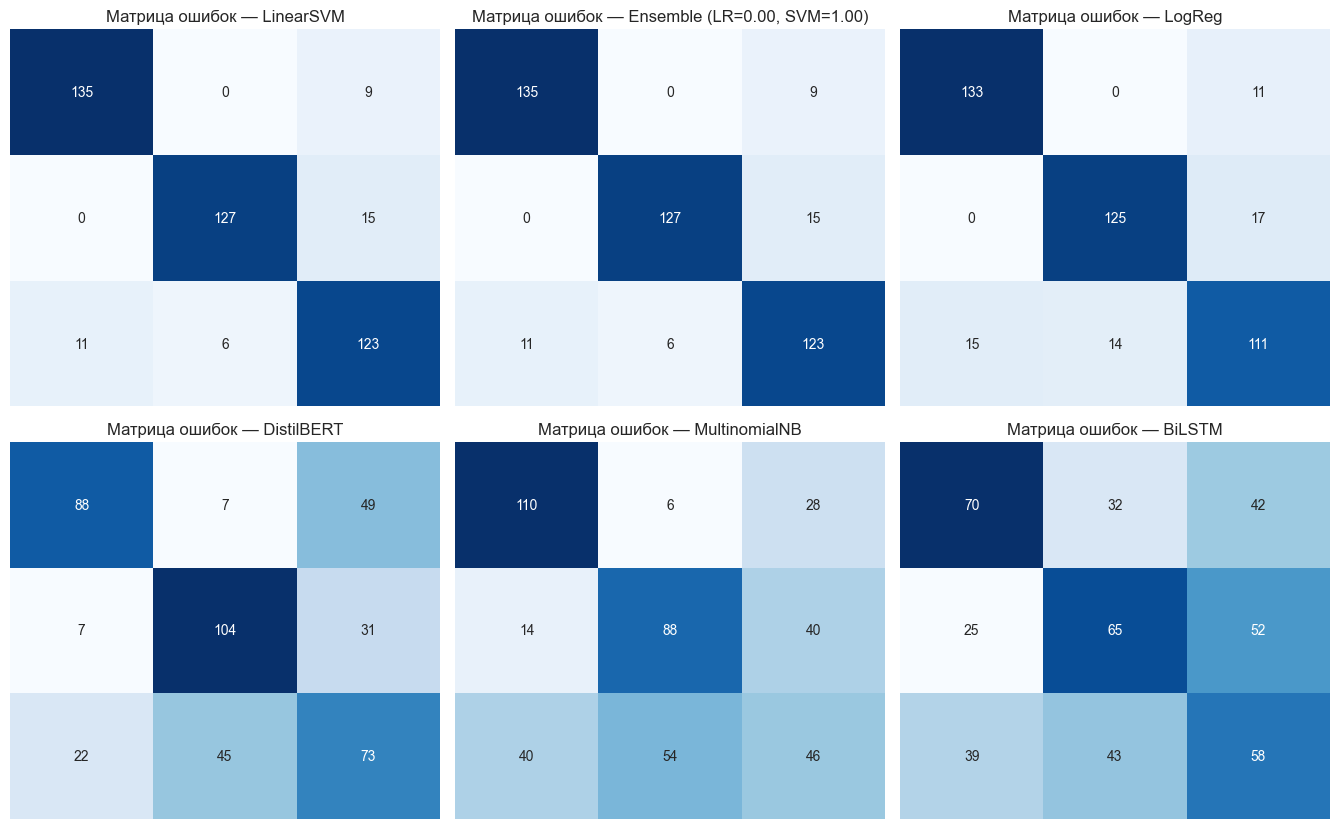

In [60]:

models_to_plot = summary_df.index.tolist()
cols = 3
rows = int(np.ceil(len(models_to_plot) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4.5, rows * 4.2))
axes = np.array(axes).reshape(rows, cols)

for ax in axes.ravel():
    ax.axis('off')

for ax, model_name in zip(axes.ravel(), models_to_plot):
    cm_df = confusion_matrices[model_name]
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'Матрица ошибок — {model_name}')
    ax.set_xlabel('Предсказано')
    ax.set_ylabel('Истинно')

plt.tight_layout()
plt.show()


In [61]:

from IPython.display import display

best_model_name = max(evaluation_results.items(), key=lambda item: item[1]['macro_f1'])[0]
analysis_df = test_df.copy().reset_index(drop=True)
for model_name, preds in model_predictions.items():
    analysis_df[model_name] = preds

analysis_df['best_model'] = model_predictions[best_model_name]
analysis_df['best_confidence'] = model_probabilities[best_model_name].max(axis=1)
analysis_df['word_count'] = analysis_df['combined_text'].str.split().str.len()
analysis_df['length_bin'] = pd.cut(
    analysis_df['word_count'],
    bins=[0, 120, 240, 480, np.inf],
    labels=['<=120', '121-240', '241-480', '>480'],
    include_lowest=True
)

mistakes = analysis_df[analysis_df[target_col] != analysis_df['best_model']]
print(f'Лучший модельный кандидат: {best_model_name}')
print(f'Всего ошибок на тесте: {len(mistakes)} из {len(test_df)}')

display(mistakes.sort_values('best_confidence', ascending=False)[[
    target_col,
    'best_model',
    'best_confidence',
    'word_count',
    'combined_text'
]].head(10))

if not mistakes.empty:
    error_distribution = (
        mistakes.groupby('length_bin').size() / analysis_df.groupby('length_bin').size()
    ).fillna(0).rename('error_rate').round(3)
    display(error_distribution)
else:
    print('Ошибок нет на тестовом наборе.')


Лучший модельный кандидат: LinearSVM
Всего ошибок на тесте: 41 из 426


,complexity,best_model,best_confidence,word_count,combined_text
418,Medium,Hard,0.981849,882,csa chief who quit still in job the head of th...
339,Medium,Easy,0.970489,1604,apple laptop is greatest gadget the apple powe...
232,Medium,Easy,0.968808,1308,apple laptop is greatest gadget the apple powe...
379,Hard,Medium,0.955257,373,argentina closes bn debt swap argentina is set...
0,Medium,Easy,0.944669,295,fockers fuel festive film chart comedy meet th...
362,Medium,Hard,0.931866,324,injury doubts beset wales squad wales have a c...
230,Hard,Medium,0.922772,329,strachan turns down pompey former southampton ...
190,Medium,Hard,0.912208,336,lloyd s of london head chides fsa the head of ...
328,Hard,Medium,0.885607,394,worldcom director ends evidence the former chi...
153,Easy,Medium,0.863211,231,collins appeals against drugs ban sprinter mic...


C:\Users\matve\AppData\Local\Temp\ipykernel_26476\1042605464.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mistakes.groupby('length_bin').size() / analysis_df.groupby('length_bin').size()
C:\Users\matve\AppData\Local\Temp\ipykernel_26476\1042605464.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mistakes.groupby('length_bin').size() / analysis_df.groupby('length_bin').size()


length_bin
<=120      0.000
121-240    0.100
241-480    0.094
>480       0.099
Name: error_rate, dtype: float64

In [62]:
def generate_tts_samples(df_source, samples_per_class=3, output_dir=Path('tts_samples')):
    output_dir.mkdir(parents=True, exist_ok=True)
    metadata = []
    for label in ['Easy', 'Medium', 'Hard']:
        subset = df_source[df_source[target_col] == label]
        sampled = subset.sample(n=min(samples_per_class, len(subset)), random_state=SEED)
        for idx, row in sampled.iterrows():
            filename = output_dir / f'{label.lower()}_{idx}.aiff'
            text_to_say = row['text'].replace("'", '')
            if not filename.exists():
                subprocess.run(['say', text_to_say, '-o', str(filename)], check=True)
            metadata.append({
                'complexity': label,
                'text_id': int(idx),
                'audio_path': str(filename),
                'text': row['text'][:1000]
            })
    meta_df = pd.DataFrame(metadata)
    meta_path = output_dir / 'tts_metadata.csv'
    meta_df.to_csv(meta_path, index=False)
    return meta_df

tts_meta = generate_tts_samples(train_full, samples_per_class=2)
tts_meta.head()

,complexity,text_id,audio_path,text
0,Easy,761,tts_samples\easy_761.aiff,T in the Park sells out in days\r\n\r\nTickets...
1,Easy,1295,tts_samples\easy_1295.aiff,Holmes secures comeback victory\r\n\r\nBritain...
2,Medium,2092,tts_samples\medium_2092.aiff,Have hackers recruited your PC?\r\n\r\nMore th...
3,Medium,971,tts_samples\medium_971.aiff,Guantanamo man 'suing government'\r\n\r\nA Bri...
4,Hard,430,tts_samples\hard_430.aiff,China bans new tobacco factories\r\n\r\nThe wo...


### Использование аудио-данных
- Файлы в папке `tts_samples/` — синтетические аудиоверсии текстов разных уровней сложности, что приближает задачу к классификации голосовых сообщений из Telegram.
- Дальше можно применять ASR для автоматической транскрибации голосовых данных и повторно использовать обученный классификатор сложности.
- Метаданные `tts_metadata.csv` сохраняют связь между audio и текстом для дальнейшего обучения или валидации.

## Выводы
- Классические модели на TF-IDF и читаемостных признаках остаются лучшими: Linear SVM и ансамбль (равный по весам SVM) дают ~0.90 accuracy и macro-F1.
- BiLSTM на PyTorch пока уступает бенчмарку (~0.44 macro-F1) — модели не хватает данных и предобученных эмбеддингов; перспективно добавить готовые word embeddings и увеличить число эпох.
- DistilBERT, обученный на CPU и 2 эпохах, улучшил результаты по сравнению с наивным байесом, но заметно отстаёт от SVM; дополнительное дообучение на GPU и подбор гиперпараметров должны подтянуть качество.
- Ошибки концентрируются в классе Medium и среднем диапазоне длин; стоит пробовать тонкую настройку class_weight, увеличение контекста и расширение корпуса.
